In [1]:
# Uncomment line below if LOAD_PATH returns only 2
push!(LOAD_PATH,"/Users/ilanfilonenko/.julia/v0.6/FixedPointNumbers");
# Uncomment line below if PyPlot isn't installed in you v0.6.0 .julia environment 
#   This system assumes usage of Python2.7 in your .julia environment
# Pkg.add("PyPlot")
# LOAD_PATH

In [2]:
# Push local directory to get access to GradientModels
push!(LOAD_PATH,pwd());

In [3]:
LOAD_PATH

4-element Array{Any,1}:
 "/Applications/Julia-0.6.app/Contents/Resources/julia/local/share/julia/site/v0.6"
 "/Applications/Julia-0.6.app/Contents/Resources/julia/share/julia/site/v0.6"      
 "/Users/ilanfilonenko/.julia/v0.6/FixedPointNumbers"                              
 "/Users/ilanfilonenko/sgd-vr-precision/experiments"                               

In [4]:
using PyPlot

In [5]:
using GradientModels

In [6]:
using FixedPointNumbers

In [7]:
# Data Generation
srand(424242)
d = 20;
N = 10000;
wtrue = randn(d);
wtrue = d^2 * wtrue / norm(wtrue);
X = randn(N, d);
X ./= sqrt.(sum(X.^2, 2));
Y = (1 ./ (1 + exp.(-X * wtrue)) .>= rand(N)) * 2 - 1;
sigma = 0.001;
mu = sigma;
M = 1;
# find the true minimum
function newton_logreg(w0, X, Y, sigma, niters)
    N = size(X, 1);
    d = size(X, 2);
    w = w0;
    for k = 1:niters
        g = -X' * (Y ./ (1 + exp.(Y .* (X * w)))) + N * sigma * w;
        H = X' * ((1 ./ ((1 + exp.(Y .* (X * w))) .* (1 + exp.(-Y .* (X * w))))) .* X) + N * sigma * eye(d);
        w = w - H \ g;
    end
    return w
end
wopt = newton_logreg(wtrue, X, Y, sigma, 10);

$$\alpha_t = \frac{2 \mu \| w_0 - w^* \|^2}{4 M + \mu^2 \| w_0 - w^* \|^2 t}$$

$$\alpha_t = \frac{\alpha_0}{1 + \gamma t}$$
$$\alpha_0 = \frac{2 \mu \| w_0 - w^* \|^2}{4 M}$$

In [8]:
w0 = randn(d);

In [9]:
alpha0 = 2 * mu * norm(w0 - wopt)^2 / (4 * M);

Optimal step size from our analysis was
$$\alpha = \frac{\mu}{5 L^2 e}$$
and optimal epoch length was
$$T = \frac{5 L^2 e}{\mu^2}$$.

Must generate a training set at random from the generative model associated with logistic regression.
This generative model is, for label $y \in \{-1,1\}$, features $x \in \mathbb{R}^d$ and model $w \in \mathbb{R}^d$,

$$\mathbf{P}_w(y | x) = \frac{1}{1 + \exp(-y x^T w)}.$$

Since $$\phi_{k,i} = x_i^T w.$$

$$p(\phi) = \prod_{i=1}^N \frac{1}{1 + \exp(y_i \phi_{k,i})}$$

and so maximizing this is equivalent to maximizing the log likelihood

$$\log p(\phi) = -\sum_{i=1}^N \log \left( 1 + \exp(y_i \phi_{k,i}) \right).$$

The gradient of this is

$$\nabla \log p(\phi) = \sum_{i=1}^N \frac{y_i}{1 + \exp(y_i \phi_{k,i})}.$$

Anyway, we can see that this corresponds to logistic regression.

In [10]:
log_loss = ((p,i,X,Y) -> log(1 + exp.(-Y[i] * p[i])));
g_log_loss = ((p,i,X,Y) -> (Y[i] / (1 + exp.(-Y[i] * p[i]))));

In [14]:
R = Scaled{Int16,15,1./12800,Randomized};
blue = 8;
purple = 8;
mu = 0.001;

In [31]:
(w,dto_svrg) = LMHALP{0.1,50,5,R}(w0,wopt,X,Y,blue,purple,mu,g_log_loss);

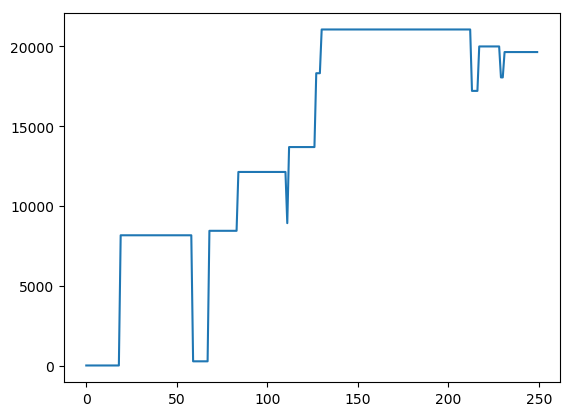

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1391551d0>

In [32]:
plot(dto_svrg)